# Iteratively Train Model
* functions for importing, processing data, and fitting model
* imports one "chunk" of data at a time
* updates the model with current "chunk"

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.utils.class_weight import compute_class_weight

# Visualization function

import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show() 

    
# Find most common words

temp = pd.read_csv('Data/cv-valid-train.csv')
texts = temp['text']

words_list = np.hstack([x.split(' ') for x in texts])
words_list_df = pd.Series(words_list)
temp = words_list_df.value_counts()

common_words = temp[:1000]
for ind in range(1000,len(temp)):
    num_freq = common_words[-1]
    if temp[ind] == num_freq:
        common_words = pd.concat([common_words,temp[ind:ind+1]])
    else: break
print(common_words)





temp = None
texts = None
words_list = None

num_unrec = round((len(words_list_df)-sum(common_words))*.005)
temp = pd.Series(num_unrec)
temp.index = ['[UNRECOGNIZED]']
words_list = pd.concat([common_words,temp])

lb = LabelBinarizer()
lb.fit(words_list.index)

class_weight_dict = {}
for ind in range(len(words_list)):
    word = words_list.index[ind]
    word_ind = lb.transform([word]).argmax()
    class_weight_dict[word_ind] = sum(words_list)/(len(words_list)*words_list[ind])
weight_dict_sorted = dict(sorted(class_weight_dict.items()))

the             141274
to               55997
and              41557
a                40516
of               36293
                 ...  
specifically       230
rushing            230
carried            230
olympics           230
past               230
Length: 1009, dtype: int64


In [2]:
# import and preprocess data

def import_data(sample_to_fit):
    sample_to_fit = 1
    file_name = 'Data/Samples_'+str(sample_to_fit)+'.csv'

    df = pd.read_csv(file_name)
    df['words'] = df['words'].where(df['words'].isin(common_words.index),'[UNRECOGNIZED]')
    temp = df.loc[df['words']=='[UNRECOGNIZED]']
    df_1 = df.loc[df['words']!='[UNRECOGNIZED]']
    df_2 = temp.sample(frac=0.005)
    df = pd.concat([df_1,df_2])
    return df

In [3]:
# Process dataframe for model fitting

def process_data(df,lb):
    X = df.drop('words',axis=1)
    y_raw = df['words']

    y = lb.transform(y_raw)


    X_train,X_val,y_train,y_val = train_test_split(X,y)
    ss = StandardScaler()
    X_train_scale = ss.fit_transform(X_train)
    X_val_scale = ss.transform(X_val)
    X_train_final = X_train_scale.reshape(X_train.shape[0],3000,1)
    X_val_final = X_val_scale.reshape(X_val.shape[0],3000,1)
    
    return X_train_final,y_train,X_val_final,y_val

In [4]:
# function to train model with new data

def model_fit(model,X_train_final,y_train,X_val_final,y_val,verb):
    start = datetime.now()
    
    count = 0
    weights = {}
    uni_y_t = np.unique(np.argmax(y_train,axis=1))
    for uni in uni_y_t:
        weights[count]=weight_dict_sorted[uni]
        count += 1
    all_y = np.concatenate((y_train,y_val))
    uni_y = np.unique(np.argmax(all_y,axis=1))
    diff = len(all_y)-len(uni_y)
    for extra in range(diff):
        weights[count]=0
        count+=1
    
    results=model.fit(X_train_final,y_train,epochs=6,batch_size=100,validation_data=(X_val_final,y_val),
                    class_weight = weights,verbose=verb)
    end=datetime.now()

    print('\nTime training: ',end-start)
    results_train = model.evaluate(X_train_final,y_train)
    print('----------')
    print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
    results_val = model.evaluate(X_val_final,y_val)
    print('----------')
    print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

    visualize_training_results(results)
    return model

In [5]:
#initialize model

gru = keras.models.Sequential()
gru.add(keras.layers.Bidirectional(keras.layers.GRU(16, input_shape=(3000,1,))))
gru.add(keras.layers.Dense(1010,activation='softmax'))
gru.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])

Starting Time for set 1: 2020-10-30 23:01:16.203208
Data Imported, Time Elapsed: 0:00:27.400813
Data Processed, Time Elapsed: 0:00:20.168184
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Time training:  2:37:23.508478
30675/30675 [==============================] - 348s 11ms/sample - loss: 5.9683 - accuracy: 0.0336
----------
Training Loss: 5.97 
Training Accuracy: 0.0336
10225/10225 [==============================] - 117s 11ms/sample - loss: 5.9941 - accuracy: 0.0344
----------
Validation Loss: 5.99 
Validation Accuracy: 0.0344


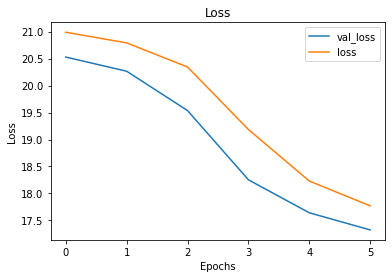

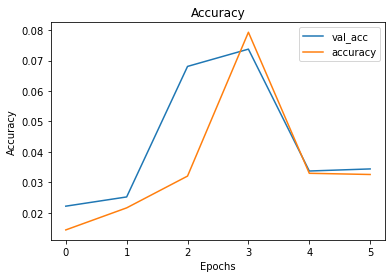

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_in_progress\assets
Starting Time for set 2: 2020-10-31 01:47:48.249186
Data Imported, Time Elapsed: 0:00:39.883948
Data Processed, Time Elapsed: 0:00:35.767056
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Time training:  2:39:49.023586
30675/30675 [==============================] - 351s 11ms/sample - loss: 5.9324 - accuracy: 0.0252
----------
Training Loss: 5.93 
Training Accuracy: 0.0252
10225/10225 [==============================] - 116s 11ms/sample - loss: 5.9579 - accuracy: 0.0247
----------
Validation Loss: 5.96 
Validation Accuracy: 0.0247


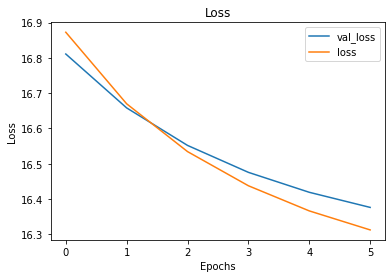

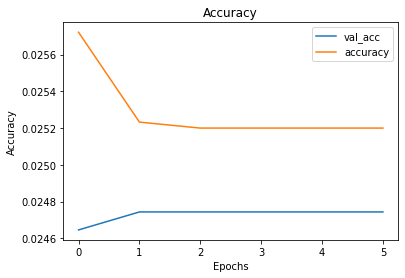

INFO:tensorflow:Assets written to: model_in_progress\assets
Starting Time for set 3: 2020-10-31 04:37:45.357654
Data Imported, Time Elapsed: 0:00:50.309299
Data Processed, Time Elapsed: 0:02:17.351709
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Time training:  2:41:18.159497
30675/30675 [==============================] - 287s 9ms/sample - loss: 5.9606 - accuracy: 0.0250
----------
Training Loss: 5.96 
Training Accuracy: 0.025
10225/10225 [==============================] - 98s 10ms/sample - loss: 5.9683 - accuracy: 0.0252
----------
Validation Loss: 5.97 
Validation Accuracy: 0.0252


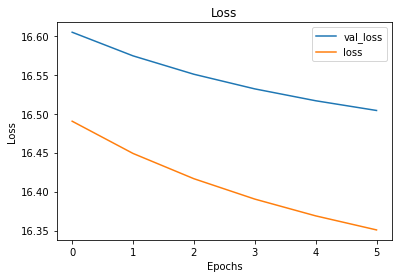

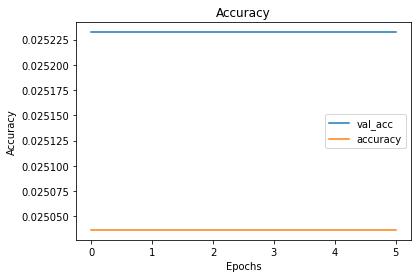

INFO:tensorflow:Assets written to: model_in_progress\assets


In [6]:
# Now put it all together

for x in range(1,4):
    dt_1 = datetime.now()
    print(f'Starting Time for set {x}: {dt_1}')
    df = import_data(x)
    dt_2 = datetime.now()
    print('Data Imported, Time Elapsed:',dt_2-dt_1)
    X_t,y_t,X_v,y_v = process_data(df,lb)
    dt_3 = datetime.now()
    print('Data Processed, Time Elapsed:',dt_3-dt_2)
    gru = model_fit(gru,X_t,y_t,X_v,y_v,False)
    gru.save('model_in_progress')